In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mv /content/drive/MyDrive/places205.zip /content/

In [6]:
!unzip /content/places205.zip -d /content/
%cd /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00002282.jpg  
  inflating: /content/places205_reduced/train_256/lake/natural/00004195.jpg  
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00004195.jpg  
  inflating: /content/places205_reduced/train_256/lake/natural/00003822.jpg  
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00003822.jpg  
  inflating: /content/places205_reduced/train_256/lake/natural/00001562.jpg  
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00001562.jpg  
  inflating: /content/places205_reduced/train_256/lake/natural/00003375.jpg  
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00003375.jpg  
  inflating: /content/places205_reduced/train_256/lake/natural/00003413.jpg  
  inflating: /content/__MACOSX/places205_reduced/train_256/lake/natural/._00003413.jpg  
  inflating: /content/pla

In [13]:
!cd /content/

In [14]:
!ls

drive  __MACOSX  places205_reduced  places205.zip  sample_data


In [20]:
# Set the path to your dataset
base_path = '/content/places205_reduced/train_256'

# Classes with subdirectory issues
problematic_classes = ['field', 'forest', 'lake', 'library']

# Function to remove subdirectories and move images to parent directory
def flatten_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            for subitem in os.listdir(item_path):
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isfile(subitem_path) and subitem.lower().endswith(('.jpg', '.jpeg', '.png')):
                    # Generate a unique filename if the destination file already exists
                    destination_path = os.path.join(directory, subitem)
                    if os.path.exists(destination_path):
                        base, ext = os.path.splitext(subitem)
                        counter = 1
                        new_filename = f"{base}_{counter}{ext}"
                        destination_path = os.path.join(directory, new_filename)
                        while os.path.exists(destination_path):
                            counter += 1
                            new_filename = f"{base}_{counter}{ext}"
                            destination_path = os.path.join(directory, new_filename)
                    shutil.move(subitem_path, destination_path)
            shutil.rmtree(item_path)
    print(f"Flattened directory: {directory}")

# Flatten problematic class directories
for class_name in problematic_classes:
    class_path = os.path.join(base_path, class_name)
    if os.path.exists(class_path):
        flatten_directory(class_path)
    else:
        print(f"Directory not found: {class_path}")

# Verify the directory structure
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        subdirs = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]
        if subdirs:
            print(f"Warning: {class_name} still has subdirectories: {subdirs}")
        else:
            print(f"{class_name}: Flattened successfully")

Flattened directory: /content/places205_reduced/train_256/field
Flattened directory: /content/places205_reduced/train_256/forest
Flattened directory: /content/places205_reduced/train_256/lake
Flattened directory: /content/places205_reduced/train_256/library
beach: Flattened successfully
playground: Flattened successfully
park: Flattened successfully
bathroom: Flattened successfully
lake: Flattened successfully
classroom: Flattened successfully
highway: Flattened successfully
mountain: Flattened successfully
library: Flattened successfully
office: Flattened successfully
restaurant: Flattened successfully
field: Flattened successfully
lobby: Flattened successfully
forest: Flattened successfully
kitchen: Flattened successfully
bedroom: Flattened successfully


In [24]:
# Parameters
IMG_SIZE = 380
BATCH_SIZE = 32

# Create datasets
ds_train = image_dataset_from_directory(
    base_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

ds_val = image_dataset_from_directory(
    base_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Print class distribution
class_names = ds_train.class_names
print("Class names:", class_names)

for dataset, name in [(ds_train, "Training"), (ds_val, "Validation")]:
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    print(f"\n{name} set class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

NUM_CLASSES = len(class_names)
print(f"\nNumber of classes: {NUM_CLASSES}")

# The rest of the script (model definition, training, etc.) remains the same as in the previous response

Found 80000 files belonging to 16 classes.
Using 64000 files for training.
Found 80000 files belonging to 16 classes.
Using 16000 files for validation.
Class names: ['bathroom', 'beach', 'bedroom', 'classroom', 'field', 'forest', 'highway', 'kitchen', 'lake', 'library', 'lobby', 'mountain', 'office', 'park', 'playground', 'restaurant']

Training set class distribution:
playground: 4030
park: 4007
field: 3997
library: 3995
classroom: 3994
mountain: 3973
kitchen: 3995
bathroom: 3966
highway: 4035
forest: 4023
lake: 3999
restaurant: 4045
beach: 3989
lobby: 3942
office: 4018
bedroom: 3992

Validation set class distribution:
park: 993
bathroom: 1034
field: 1003
lake: 1001
lobby: 1058
forest: 977
highway: 965
library: 1005
bedroom: 1008
office: 982
kitchen: 1005
classroom: 1006
restaurant: 955
playground: 970
mountain: 1027
beach: 1011

Number of classes: 16


In [22]:
import os
import shutil
import random

# Set the path to your dataset
base_path = '/content/places205_reduced/train_256'

# Target number of images per class
train_target = 4000
val_target = 1000

def split_shuffle_and_reduce(directory, train_target, val_target):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(images)

            # Create validation subdirectory if it doesn't exist
            val_class_path = os.path.join(class_path, 'val')
            os.makedirs(val_class_path, exist_ok=True)

            # Move images to validation set
            for i in range(val_target):
                shutil.move(os.path.join(class_path, images[i]), val_class_path)

            # Remove excess images from training set
            if len(images) > train_target + val_target:
                for i in range(train_target + val_target, len(images)):
                    os.remove(os.path.join(class_path, images[i]))

            print(f"{class_name}: Reduced to {train_target} training images and {val_target} validation images")

# Split, shuffle and reduce dataset
split_shuffle_and_reduce(base_path, train_target, val_target)

# Verify the distribution
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        train_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        val_images = [f for f in os.listdir(os.path.join(class_path, 'val')) if os.path.isfile(os.path.join(class_path, 'val', f))]
        print(f"{class_name}: {len(train_images)} training images and {len(val_images)} validation images")

beach: Reduced to 4000 training images and 1000 validation images
playground: Reduced to 4000 training images and 1000 validation images
park: Reduced to 4000 training images and 1000 validation images
bathroom: Reduced to 4000 training images and 1000 validation images
lake: Reduced to 4000 training images and 1000 validation images
classroom: Reduced to 4000 training images and 1000 validation images
highway: Reduced to 4000 training images and 1000 validation images
mountain: Reduced to 4000 training images and 1000 validation images
library: Reduced to 4000 training images and 1000 validation images
office: Reduced to 4000 training images and 1000 validation images
restaurant: Reduced to 4000 training images and 1000 validation images
field: Reduced to 4000 training images and 1000 validation images
lobby: Reduced to 4000 training images and 1000 validation images
forest: Reduced to 4000 training images and 1000 validation images
kitchen: Reduced to 4000 training images and 1000 va

In [26]:
#Data Augmentation
img_augmentation = Sequential([
    layers.RandomRotation(factor=0.05),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomBrightness(factor=0.1),
], name='img_augmentation')

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)

    base_model = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")

    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# Create the model
model = build_model()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [27]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
save_best = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False
)

# Train the model
epochs = 10
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[early_stopping, reduce_lr, save_best]
)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1260s 589ms/step - accuracy: 0.5953 - loss: 1.7385 - val_accuracy: 0.8539 - val_loss: 0.6986 - learning_rate: 1.0000e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1175s 587ms/step - accuracy: 0.7994 - loss: 0.8523 - val_accuracy: 0.8569 - val_loss: 0.6148 - learning_rate: 1.0000e-04
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1180s 590ms/step - accuracy: 0.8335 - loss: 0.6713 - val_accuracy: 0.8694 - val_loss: 0.5265 - learning_rate: 1.0000e-04
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1174s 587ms/step - accuracy: 0.8569 - loss: 0.5440 - val_accuracy: 0.8649 - val_loss: 0.5132 - learning_rate: 1.0000e-04
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1166s 583ms/step - accuracy: 0.8759 - loss: 0.4482 - val_accuracy: 0.8668 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1169s 584ms/step - accuracy: 0.8911 - loss: 0.3772 - val_accuracy: 0.8621 - val_loss: 0.5011 - learning_rate: 1.0000e-04
Epoch 7/10
2000/2000 ━

500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.8732 - loss: 0.4827
Test accuracy: 0.87


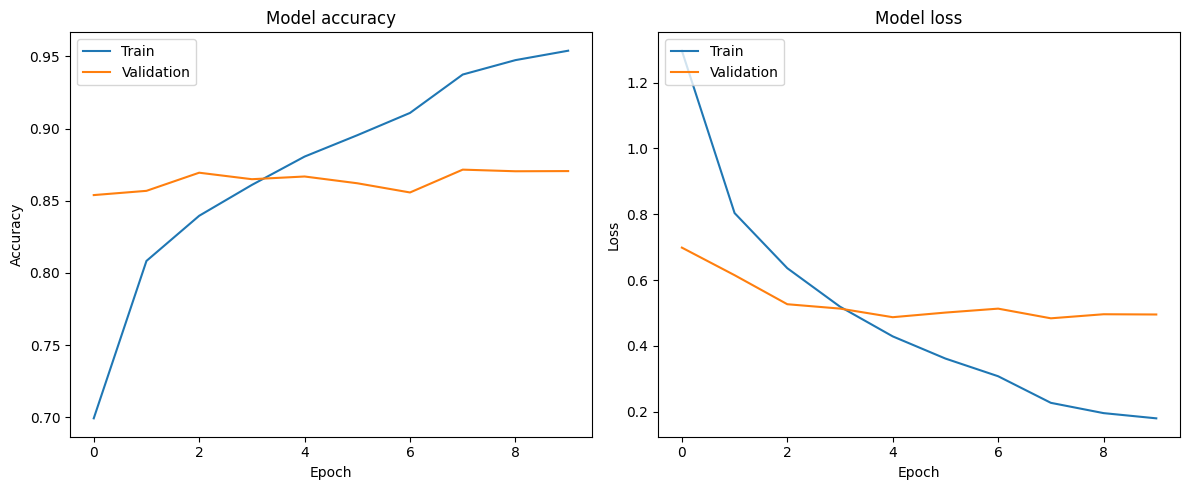

Class names: ['bathroom', 'beach', 'bedroom', 'classroom', 'field', 'forest', 'highway', 'kitchen', 'lake', 'library', 'lobby', 'mountain', 'office', 'park', 'playground', 'restaurant']
['bounding_box_test', 'Colab Notebooks', 'torchreid', 'Untitled document (1).gdoc', 'osnet_ain_x1_0-softmax-combined.zip', 'osnet_ain_x1_0-Market1501_DukeMTMC_cuhk03_ilids', 'person_reidentification', 'archive', 'Untitled0.ipynb', 'LUPerson.ipynb', 'requirements_after_install.txt', 'list_train.txt.zip', 'fastreid.zip', 'LUPerson_finetuning.ipynb', 'LUPerson_tutorial.ipynb', 'object_detect.gdoc', 'Untitled2.ipynb', 'Untitled1.ipynb', 'hybrik.zip', 'Untitled3.ipynb', 'Untitled4.ipynb', 'Untitled document.gdoc', 'resnet152v2_weights.zip', 'metrics', 'best_resnet152v2.h5', 'Untitled5.ipynb', 'Untitled', 'florence2.ipynb', 'florence2+sam2.ipynb', 'places205_reduced', 'Untitled6.ipynb', 'Untitled7.ipynb', 'best_model.keras', 'training_plot.png']


In [28]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(ds_val)
print(f"Test accuracy: {test_accuracy:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_plot.png')
plt.show()

print("Class names:", class_names)
print(os.listdir('/content/drive/MyDrive'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

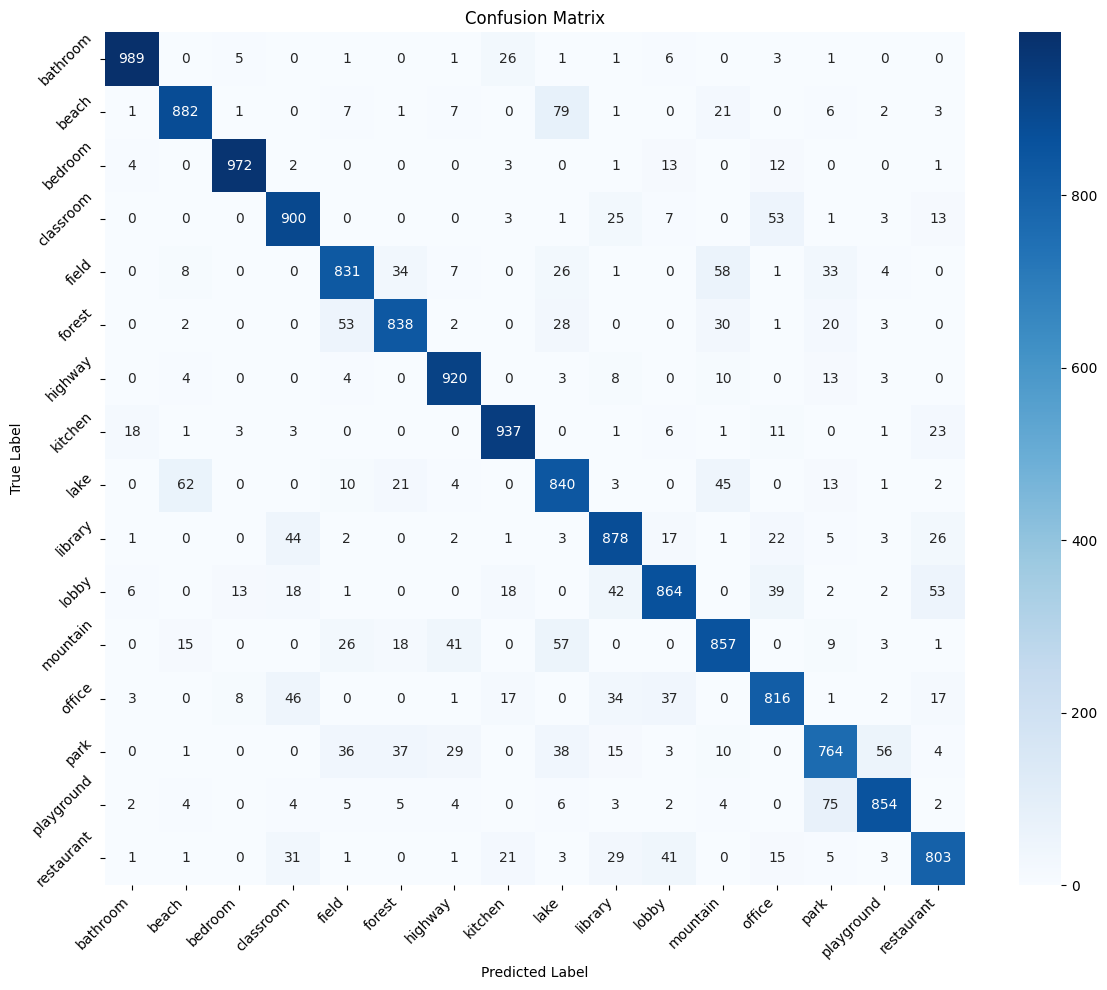

              precision    recall  f1-score   support

    bathroom       0.96      0.96      0.96      1034
       beach       0.90      0.87      0.89      1011
     bedroom       0.97      0.96      0.97      1008
   classroom       0.86      0.89      0.88      1006
       field       0.85      0.83      0.84      1003
      forest       0.88      0.86      0.87       977
     highway       0.90      0.95      0.93       965
     kitchen       0.91      0.93      0.92      1005
        lake       0.77      0.84      0.81      1001
     library       0.84      0.87      0.86      1005
       lobby       0.87      0.82      0.84      1058
    mountain       0.83      0.83      0.83      1027
      office       0.84      0.83      0.83       982
        park       0.81      0.77      0.79       993
  playground       0.91      0.88      0.89       970
  restaurant       0.85      0.84      0.84       955

    accuracy                           0.87     16000
   macro avg       0.87   

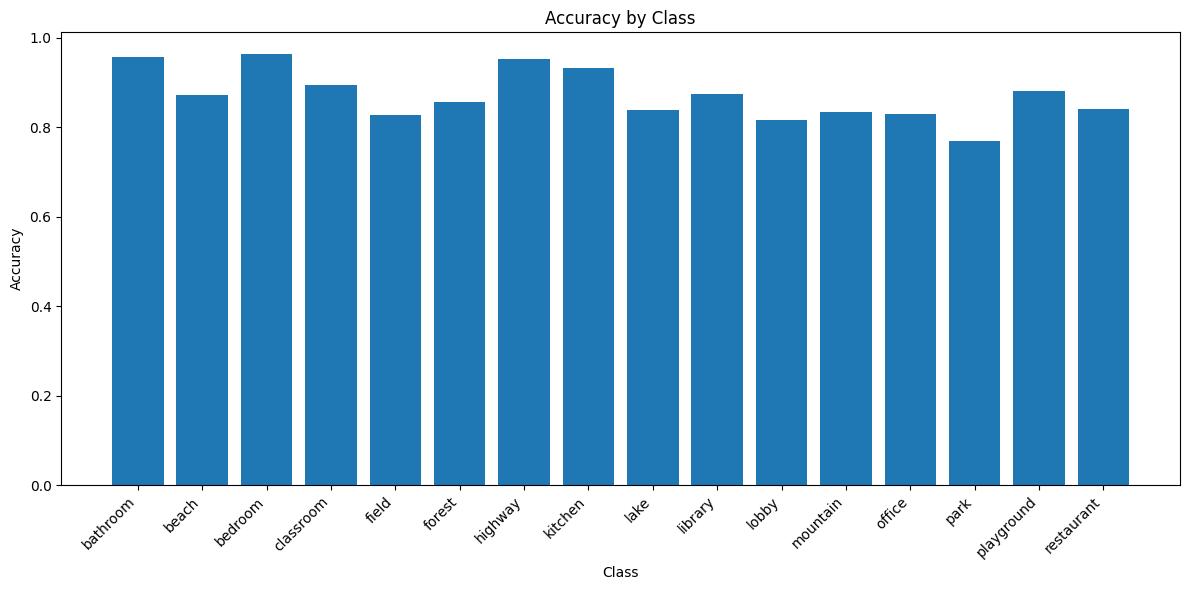

bathroom: 0.96 (989/1034)
beach: 0.87 (882/1011)
bedroom: 0.96 (972/1008)
classroom: 0.89 (900/1006)
field: 0.83 (831/1003)
forest: 0.86 (838/977)
highway: 0.95 (920/965)
kitchen: 0.93 (937/1005)
lake: 0.84 (840/1001)
library: 0.87 (878/1005)
lobby: 0.82 (864/1058)
mountain: 0.83 (857/1027)
office: 0.83 (816/982)
park: 0.77 (764/993)
playground: 0.88 (854/970)
restaurant: 0.84 (803/955)


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataset, class_names):
    y_pred = []
    y_true = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, target_names=class_names))

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, ds_val, class_names)

def analyze_prediction_distribution(y_true, y_pred, class_names):
    correct_pred = np.array(y_true) == np.array(y_pred)

    class_correct = {name: 0 for name in class_names}
    class_total = {name: 0 for name in class_names}

    for i in range(len(y_true)):
        label = class_names[y_true[i]]
        class_total[label] += 1
        if correct_pred[i]:
            class_correct[label] += 1

    accuracies = {name: class_correct[name] / class_total[name] for name in class_names}

    plt.figure(figsize=(12, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Accuracy by Class')
    plt.ylabel('Accuracy')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    for name in class_names:
        print(f"{name}: {accuracies[name]:.2f} ({class_correct[name]}/{class_total[name]})")

# Analyze prediction distribution
analyze_prediction_distribution(y_true, y_pred, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


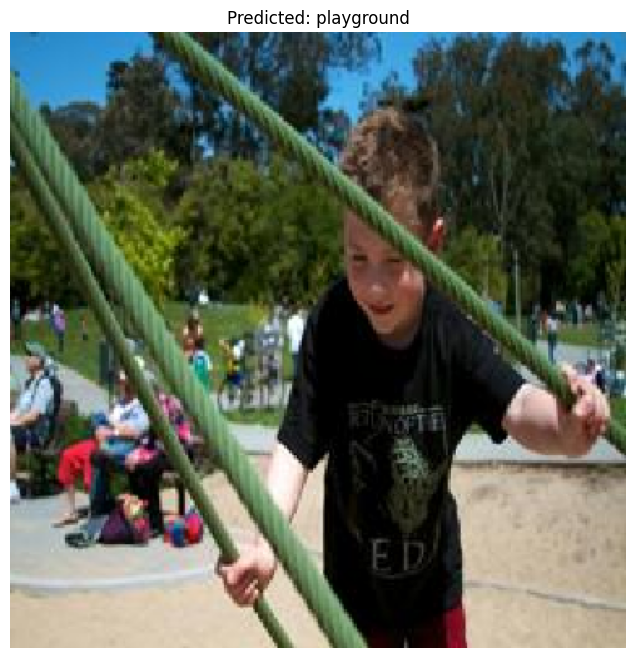

The model predicts this image as: playground


In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.keras')

# Set the path to the validation dataset
val_path = '/content/places205_reduced/val_256'

# Set the image size
IMG_SIZE = 380

# Define the correct class names
class_names = ['bathroom', 'beach', 'bedroom', 'classroom', 'field', 'forest', 'highway', 'kitchen',
               'lake', 'library', 'lobby', 'mountain', 'office', 'park', 'playground', 'restaurant']

# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to make prediction
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    return np.argmax(prediction)

# Choose an image manually (replace with your chosen image path)
chosen_image_path = '/content/places205_reduced/val_256/Places365_val_00000165.jpg'

# Make prediction
predicted_class_index = predict_image(chosen_image_path)
predicted_class = class_names[predicted_class_index]

# Display the image with the classification
plt.figure(figsize=(8, 8))
img = image.load_img(chosen_image_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()

print(f"The model predicts this image as: {predicted_class}")